# Rianna's Model Notebook

In [21]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

### Plotting functions

In [22]:
# helper function
import matplotlib.pyplot as plt

def plot_train_val_losses(eval_scores):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for fold in range(5):
        fold_scores = eval_scores[fold]
        axes[fold].plot(fold_scores['validation_0']['rmse'], label="Train Loss")
        axes[fold].plot(fold_scores['validation_1']['rmse'], label="Validation Loss")
        axes[fold].set_title(f"Fold {fold+1}")
        axes[fold].set_xlabel("Boosting Rounds")
        axes[fold].set_ylabel("RMSE Loss")
        axes[fold].legend()
    
    plt.tight_layout()
    plt.show()

In [23]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

## ML Method: XGBoost

#### Hyperparameter tuning  and regularization with RandomizedSearchCV

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [25]:
def hyperparam_search(X_train, y_train):
    param_dist = {
        'learning_rate': uniform(0.001, 0.2),
        'max_depth': randint(3, 10),
        'n_estimators': randint(50, 400),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_alpha': uniform(0, 1), # L1 regularization
        'reg_lambda': uniform(0, 10) # L2 regularization
    }

    xgb = XGBRegressor(random_state=42)

    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=20,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best hyperparameters found:", best_params)
    return best_params

#### K-Fold Cross-Validation

In [26]:
def KFold_CV(X_train, y_train, best_params):

    # 5 fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    train_mse_scores = []
    val_mse_scores = []
    eval_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        # X_train_in, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        # y_train_in, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        X_train_in, X_val = X_train[train_idx], X_train[val_idx] 
        y_train_in, y_val = y_train[train_idx], y_train[val_idx]

        xgb_model = XGBRegressor(
            **best_params,
            random_state=42,
            eval_metric="rmse",
            early_stopping_rounds=10,
            n_jobs=-1
        )

        xgb_model.fit(
            X_train_in,
            y_train_in,
            eval_set= [(X_train_in, y_train_in), (X_val, y_val)], #[(X_val, y_val)],
            verbose=False,
        )

        evals_result = xgb_model.evals_result()
        eval_scores.append(evals_result)

        y_train_pred = xgb_model.predict(X_train_in)
        y_val_pred = xgb_model.predict(X_val)

        train_mse = mean_squared_error(y_train_in, y_train_pred)
        train_mse_scores.append(train_mse)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_mse_scores.append(val_mse)

        print(f"Fold {fold + 1} — Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
        
    plot_train_val_losses(eval_scores)

    print(f"Average Train MSE: {np.mean(train_mse_scores):.4f} ± {np.std(train_mse_scores):.4f}")
    print(f"Average Validation MSE: {np.mean(val_mse_scores):.4f} ± {np.std(val_mse_scores):.4f}")

#### Test Results

In [27]:
def test_model(X_train, y_train, X_test, y_test, best_params):
    # remake new model on best params
    xgb_model = XGBRegressor(
        **best_params,
        random_state=42,
        eval_metric="rmse",
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train) # Re-fit on all training data
    y_test_pred = xgb_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    plot_actual_vs_predicted(y_test, y_test_pred)
    print(np.var(y_test))

    print(f"Final Test MSE: {test_mse:.4f}")
    print(f"Final Test R²: {test_r2:.4f}")
    return xgb_model

### Using RDKit Feature Data

In [37]:
import pickle

In [38]:
# import RDKit features data
with open("data_splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [33]:
# Use RandomizedSearchCV to find best hyperparameters
best_params = hyperparam_search(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found: {'colsample_bytree': np.float64(0.6092249700165663), 'learning_rate': np.float64(0.10595493205167783), 'max_depth': 9, 'n_estimators': 219, 'reg_alpha': np.float64(0.04666566321361543), 'reg_lambda': np.float64(9.737555188414591), 'subsample': np.float64(0.6931085361721216)}


Fold 1 — Train MSE: 0.4026, Validation MSE: 0.7395
Fold 2 — Train MSE: 0.4069, Validation MSE: 0.6583
Fold 3 — Train MSE: 0.4082, Validation MSE: 0.7605
Fold 4 — Train MSE: 0.3939, Validation MSE: 0.5512
Fold 5 — Train MSE: 0.4441, Validation MSE: 0.4954


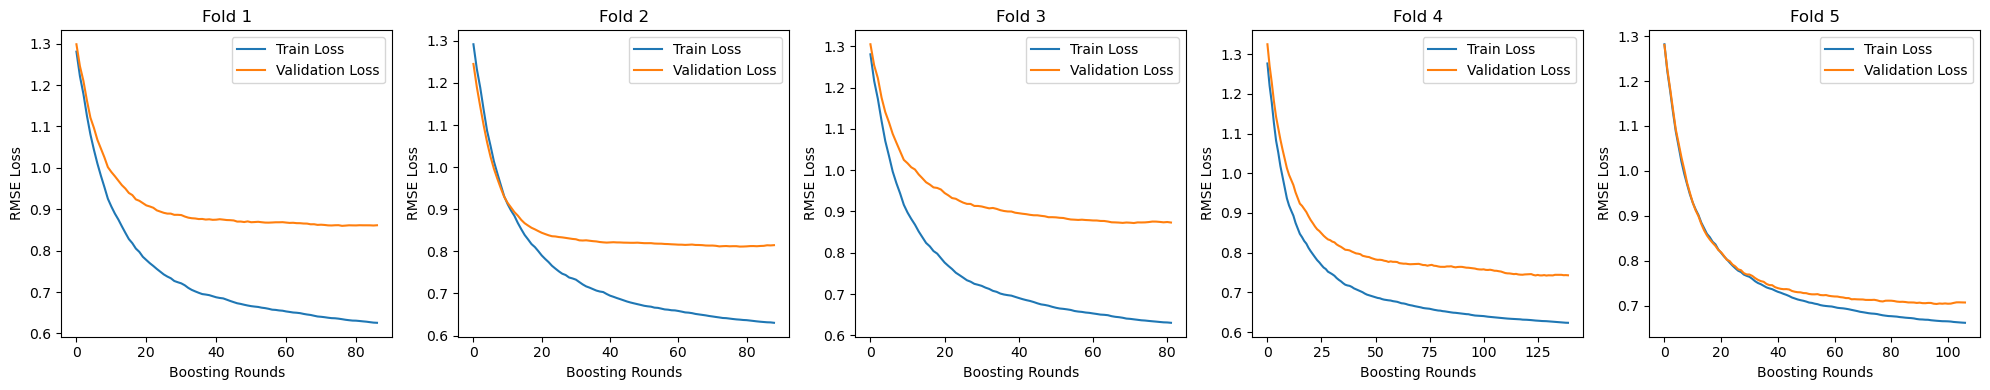

Average Train MSE: 0.4111 ± 0.0172
Average Validation MSE: 0.6410 ± 0.1035


In [34]:
# Train and validate with cross-validation
KFold_CV(X_train, y_train, best_params)

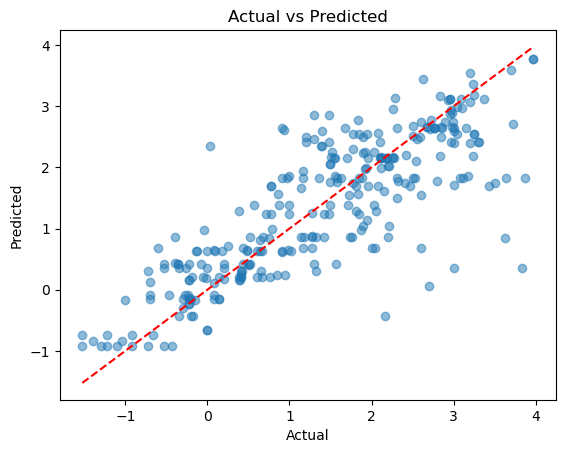

1.6623690797491995
Final Test MSE: 0.5567
Final Test R²: 0.6651


In [35]:
# Test model on unseen data
xgb_model = test_model(X_train, y_train, X_test, y_test, best_params)

[0.22391619 0.10513309 0.14538611 0.16382118 0.19461149 0.16713195]


<Figure size 800x1200 with 0 Axes>

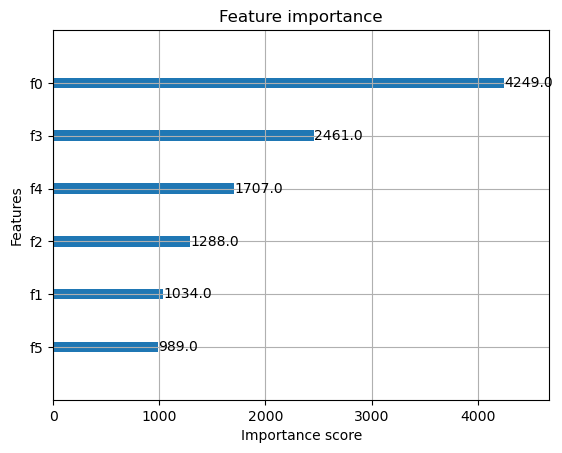

In [36]:
feat_imps = xgb_model.feature_importances_
print(feat_imps)
plt.figure(figsize=(8, 12))
xgboost.plot_importance(xgb_model)
plt.show()

### Using Morgan Fingerprint Data

In [39]:
# import morgan fingerprint data
with open("data_splits_fps.pkl", "rb") as f:
    X_train_fps, X_test_fps, y_train_fps, y_test_fps = pickle.load(f)

In [40]:
# Use RandomizedSearchCV to find best hyperparameters
best_params_fps = hyperparam_search(X_train_fps, y_train_fps)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found: {'colsample_bytree': np.float64(0.6362425738131283), 'learning_rate': np.float64(0.12467720186661746), 'max_depth': 6, 'n_estimators': 104, 'reg_alpha': np.float64(0.9832308858067882), 'reg_lambda': np.float64(4.667628932479799), 'subsample': np.float64(0.9439761626945282)}


Fold 1 — Train MSE: 0.3576, Validation MSE: 0.6592
Fold 2 — Train MSE: 0.4098, Validation MSE: 0.5835
Fold 3 — Train MSE: 0.3754, Validation MSE: 0.7585
Fold 4 — Train MSE: 0.4210, Validation MSE: 0.5767
Fold 5 — Train MSE: 0.4145, Validation MSE: 0.4297


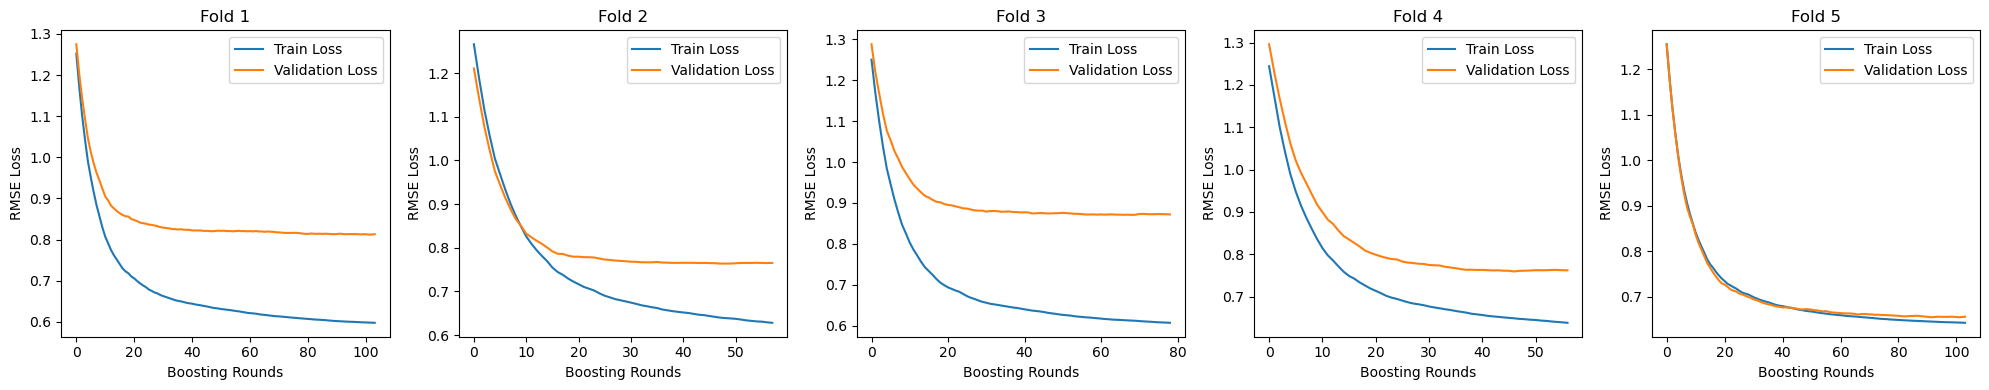

Average Train MSE: 0.3957 ± 0.0247
Average Validation MSE: 0.6015 ± 0.1081


In [41]:
# Train and validate with cross-validation
KFold_CV(X_train_fps, y_train_fps, best_params_fps)

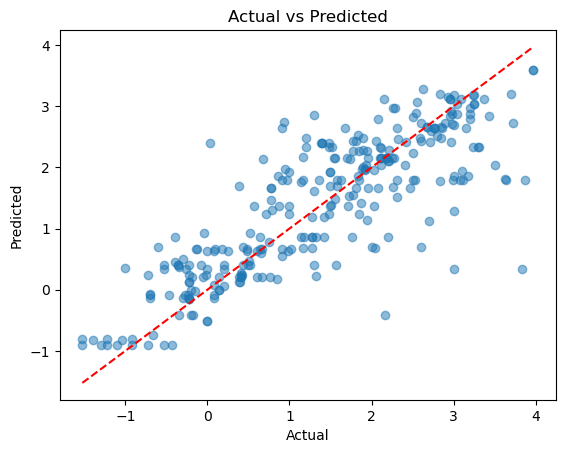

1.6623690797491995
Final Test MSE: 0.5190
Final Test R²: 0.6878


In [42]:
# Test model on unseen data
xgb_model_fps = test_model(X_train_fps, y_train_fps, X_test_fps, y_test_fps, best_params_fps)

[8.46739043e-04 4.96752153e-04 6.62523787e-04 7.06831284e-04
 2.36998242e-03 8.00864771e-04 1.09651638e-03 9.49264737e-04
 2.24339135e-04 4.76529065e-04 7.37777518e-05 2.84334575e-03
 2.04975295e-04 3.23693792e-04 3.02038214e-04 2.78000743e-03
 1.43125028e-04 5.57511885e-06 4.12482128e-04 8.11659775e-05
 8.57807405e-04 3.00914794e-03 3.12903176e-05 8.07604345e-04
 4.80949457e-05 2.00793007e-03 7.97700312e-04 0.00000000e+00
 1.94591456e-04 7.45883968e-04 6.02990476e-05 1.99014554e-04
 0.00000000e+00 7.56351836e-03 2.90791795e-04 1.42049720e-03
 9.20157239e-04 3.50236287e-03 6.12840013e-05 6.58680685e-04
 7.31999944e-06 6.24371096e-05 2.55008985e-04 1.38901114e-05
 3.12219583e-03 1.06884399e-03 1.77633206e-04 8.59675871e-04
 1.43931111e-05 3.00330692e-03 2.40214262e-03 1.98147405e-04
 0.00000000e+00 1.79612904e-03 0.00000000e+00 0.00000000e+00
 1.83524289e-08 1.06082291e-04 1.52601060e-02 2.15061678e-04
 2.06372861e-05 2.36865919e-04 3.53438190e-05 5.81257045e-03
 8.97224876e-04 7.010332

<Figure size 800x1200 with 0 Axes>

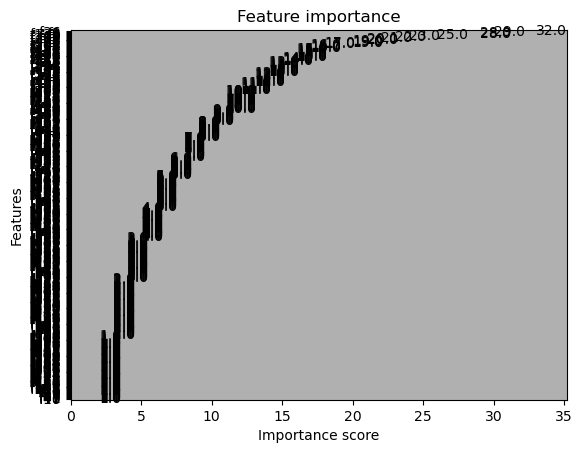

In [43]:
feat_imps_fps = xgb_model_fps.feature_importances_
print(feat_imps_fps)
plt.figure(figsize=(8, 12))
xgboost.plot_importance(xgb_model_fps)
plt.show()